# Conjugate Priors and Likelihoods

## Review

Recall from `bayes_introP.ipynb` the gun control example. $p=$ fraction of population that supports more gun control. 70 out of 100 respondents said they supported more gun control. We put a $Beta(\alpha=4,\beta=4)$ prior on $p$ and use a Bernoulli model for the responses. The prior and posterior are plotted below.

In [82]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [83]:
## get plot sizes reasonable
plt.rcParams['figure.figsize'] = (11, 3)

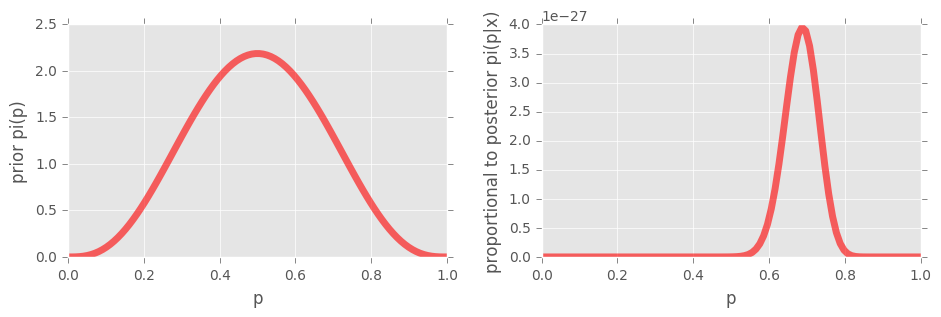

In [84]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

al = 4 ## alpha parameter
be = 4 ## beta parameter
p = np.linspace(0,1, 100)

### plot the prior
ax = fig.add_subplot(1, 2, 1)
ax.plot(p, beta.pdf(p, al, be),
         'r-', lw=5, alpha=0.6, label='beta pdf')
ax.set(xlim=(0, 1),xlabel='p', ylabel='prior pi(p)');

### plot the posterior
ax = fig.add_subplot(1, 2, 2)
ax.plot(p, beta.pdf(p, al, be)*np.power(p,70)*np.power(1.0-p,30),
         'r-', lw=5, alpha=0.6, label='beta pdf')
ax.set(xlim=(0, 1),xlabel='p', ylabel='proportional to posterior pi(p|x)');

## Numerically Normalizing the Posterior

The right plot has the shape of the posterior but is not normalized so the y-axis has no meaning. This prevents us from making probabilistic statements about $p$. For example we might want to calculate the probability that $p$ is in the interval $[0.6,0.8]$. In math this is
$$P(p \in [0.6,0.8]) = \int \pi(p|x) dp$$
However the function in the right plot is only proportional to $\pi(p|x)$. Since $\pi(p|x)$ is a probability density, $\int_{0}^1 \pi(p|x) dp = 1$. So we could normalize the right plot by numerically integrating the function. In math this is
\begin{align*}
m(x) &\gets \int f(x|p)\pi(p) dp \text{ determine normalization constant}\\
\pi(p|x) &\gets f(x|p)\pi(p) / m(x) \text{ normalize }
\end{align*}
We can then calculate $P(p \in [0.6,0.8])$ by numerically integrating $\pi(p|x)$ over $[0.6,0.8]$. We do this now.

If $f(x|p)\pi(p)$ is small then the numerical integrator tolerance for error may be close to the integral value. So we can divide $f(x|p)\pi(p)$ by its maximum value to avoid this issue.

In [85]:
def posterior_propto(p,al,be):
    return beta.pdf(p, al, be)*np.power(p,70)*np.power(1.0-p,30)

Determine the maximum.

In [86]:
p = np.linspace(0,1, 100)
fmax = np.max(posterior_propto(p,4,4))
print(fmax)

3.952609702946974e-27


In [87]:
## mathematically correct, stable, and of order 1 
def posterior_propto(p,al,be):
    return beta.pdf(p, al, be)*np.exp(70.0*np.log(p) + 30.0*np.log(1.0-p))/fmax

In [88]:
import scipy.integrate as integrate

In [89]:
mx = integrate.quad(lambda p: posterior_propto(p,4,4), 0, 1)

In [90]:
mx

(0.11209179526157621, 9.170073966355748e-09)

In [91]:
mx = mx[0]
mx

0.11209179526157621

So the posterior is

In [92]:
## mathematically correct and stable
def posterior(p,al,be):
    return beta.pdf(p, al, be)*np.exp(70.0*np.log(p) + 30.0*np.log(1.0-p))/(fmax*mx)

/home/james/.local/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


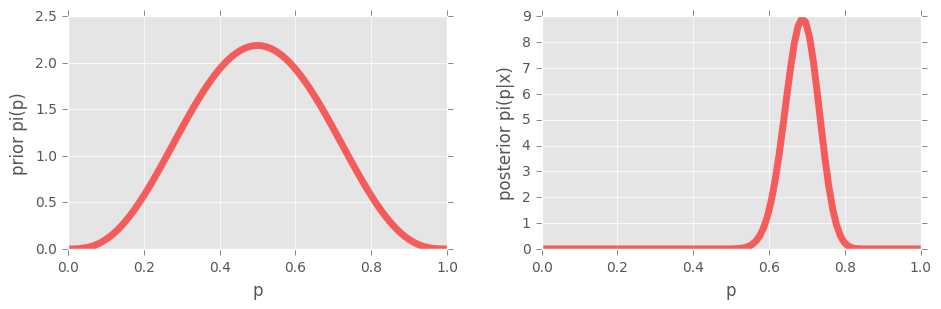

In [93]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

al = 4 ## alpha parameter
be = 4 ## beta parameter
p = np.linspace(0,1, 100)

### plot the prior
ax = fig.add_subplot(1, 2, 1)
ax.plot(p, beta.pdf(p, al, be),
         'r-', lw=5, alpha=0.6, label='beta pdf')
ax.set(xlim=(0, 1),xlabel='p', ylabel='prior pi(p)');

### plot the posterior
ax = fig.add_subplot(1, 2, 2)
ax.plot(p, posterior(p,al,be),
         'r-', lw=5, alpha=0.6, label='beta pdf')
ax.set(xlim=(0, 1),xlabel='p', ylabel='posterior pi(p|x)');

Now we can determine $P(p \in [0.6,0.8])$ by computing:

In [94]:
prob = integrate.quad(lambda p: posterior(p,4,4), 0.6, 0.8)
prob

(0.9655081093293205, 5.6606530434502065e-11)

The probability that $p \in [0.6,0.8]$ is about $0.97$. This interpretation is much simpler than frequentist confidence intervals. The drawback is that this depends on the prior and someone with a different prior opinion about $p$ will determine a different probability.

** Exercise: ** Using bisection ideas in Section 5.2.2 of Lange, compute the shortest possible 95% confidence interval for $p$.

## Normalizing the Posterior via Conjugacy

The above methods work for any likelihood $f(x|p)$ and prior $\pi(p)$ pair. However it required numerical integration, which can be computationally difficult especially in problems of more than 2 or 3 dimensions.

For some specific likelihood, prior pairs, the posterior distribution has the same form as the prior. These are known as **conjugate models.** For these models, computation is trivial. In fact, the beta and bernoulli are conjugate. That is the major reason why the beta is often used as a prior for the bernoulli.

Conjugacy is shown by demonstrating the the posterior is proportional to beta. In the beta, bernoulli case the mathematics is:

\begin{align*}
\pi(p|x) &\propto f(x|p)\pi(p)\\
&\propto p^{\sum x_i} (1-p)^{n-\sum x_i} \frac{1}{B(\alpha,\beta)} p^{\alpha-1}(1-p)^{\beta-1}\\
&\propto p^{\sum x_i + \alpha -1} (1-p)^{\beta + n-\sum x_i - 1}\\
&\propto Beta(\alpha' = \alpha + \sum x_i,\beta' = \beta + n - \sum x_i)
\end{align*}

Even though we have only shown that $\pi(p|x) \propto Beta(\alpha' = \alpha + \sum x_i,\beta' = \beta + n - \sum x_i)$, since these are both probability density functions they are in fact equal.

** Exercise: ** Derive the posterior distributions for several of the conjugate families [here](https://en.wikipedia.org/wiki/Conjugate_prior) i.e. using the first four columns in the table, derive the fifth column "Posterior hyperparameters" in the "Discrete Distributions" section and the "Continuous Distributions" section.

/home/james/.local/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


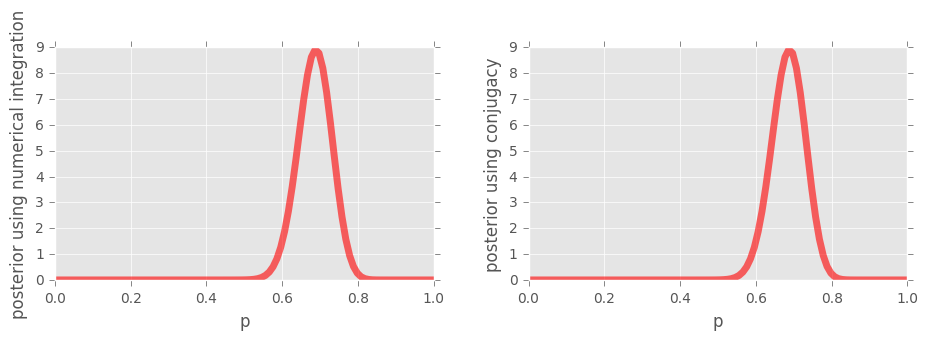

In [95]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

al = 4 ## alpha parameter
be = 4 ## beta parameter
p = np.linspace(0,1, 100)

### plot the posterior
ax = fig.add_subplot(1, 2, 1)
ax.plot(p, posterior(p,al,be),
         'r-', lw=5, alpha=0.6, label='beta pdf')
ax.set(xlim=(0, 1),xlabel='p', ylabel='posterior using numerical integration');

### plot the posterior using conjugacy result
ax = fig.add_subplot(1, 2, 2)
ax.plot(p, beta.pdf(p, al + 70, be+30),
         'r-', lw=5, alpha=0.6, label='beta pdf')
ax.set(xlim=(0, 1),xlabel='p', ylabel='posterior using conjugacy');

The results are the same. An additional advantage conjugacy is that many summaries of the posterior distribution now have closed forms. For example the posterior mean is a popular bayesian point estimator. The posterior mean is
$$p_{PM} = \int p \pi(p|x) dp$$


We can compute this from the numerically normalized posterior, but we have to perform numerical integration again.

In [96]:
def posterior_times_p(p,al,be):
    return p*beta.pdf(p, al, be)*np.exp(70.0*np.log(p) + 30.0*np.log(1.0-p))/(fmax*mx)

pm = integrate.quad(lambda p: posterior_times_p(p,4,4), 0, 1)
pm

(0.6851851851851852, 1.900498642015892e-09)

However if we know that the posterior is of the form $Beta(\alpha',\beta')$ we can look at the wikipedia page for the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) and see that the mean is
$p_{pm} = \frac{\alpha'}{\alpha' + \beta'} = \frac{4 + 70}{4 + 70 + 4 + 30}$ 

In [97]:
pm = (4.0 + 70.0)/(4.0 + 70.0 + 4.0 + 30.0)
pm

0.6851851851851852

Note that the posterior mean is less than $0.7$ (the MLE). This is because the prior is pulling our estimate a bit back towards $0.5$, what our prior belief was.

Finally we can also compute credible intervals (the bayesian version of confidence intervals) easily with the knowledge that the distribution is conjugate. For example to compute a 95% confidence interval we can find the $0.025$ and $0.975$ quantiles of $\pi(p|x)$. The quantile function is given in python and R for common distributions. Python uses the `ppf` methods to refer to quantiles.

In [98]:
lhs = beta.ppf(0.025, 74, 34)
rhs = beta.ppf(0.975, 74, 34)
print(lhs)
print(rhs)

0.5949645643680469
0.7689093453760492


In [99]:
## get plot sizes reasonable
plt.rcParams['figure.figsize'] = (7, 3)

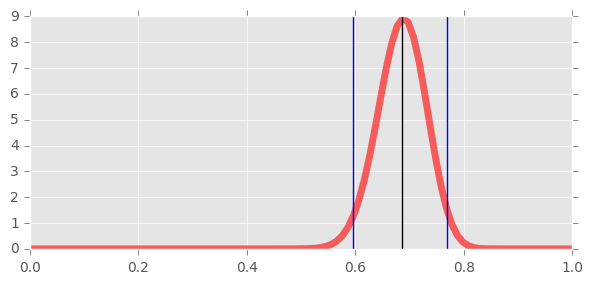

In [100]:
al = 4 ## alpha parameter
be = 4 ## beta parameter
p = np.linspace(0,1, 100)

ax = plt.axes()
### plot the posterior using conjugacy result
##ax = fig.add_subplot(1, 2, 2)
ax.plot(p, beta.pdf(p, al + 70, be+30),'r-', lw=5, alpha=0.6, label='beta pdf')
##ax.set(xlim=(0, 1),xlabel='p', ylabel='posterior using conjugacy');
ax.axvline(x=pm,color='black')
ax.axvline(x=lhs)
ax.axvline(x=rhs);

The probability that $p$ is between the blue lines (defined by lhs and rhs) is $0.95$.